In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats

## Read in  Data:

In [2]:
cat_data = pd.read_csv('./Data/cat_clean.csv')

In [3]:
# still haven't determined if these are worth using in my calculations?
df = cat_data.drop(columns=['Aggression_component', 'Shyness_component', 'Extraversion_component'])

In [29]:
df.describe()

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Behaviour_problem,ws_binary
count,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000
mean,4.753083,1.538945,0.779776,4.618407,2.546455,0.847363,3.771743,4.089067,1.116312,1.096577,1.584177,2.026546,1.884736,1.788159,1.070381,0.180580
std,3.769304,0.498525,0.414434,1.576421,1.910538,0.359669,0.864301,0.878921,0.417632,0.368069,0.840766,0.996585,1.051672,0.997117,0.384103,0.384703
min,0.167100,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.789000,1.000000,1.000000,4.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,3.879450,2.000000,1.000000,4.000000,2.000000,1.000000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
75%,6.778100,2.000000,1.000000,5.000000,5.000000,1.000000,4.000000,5.000000,1.000000,1.000000,2.000000,3.000000,2.000000,3.000000,1.000000,0.000000
max,24.811000,2.000000,1.000000,8.000000,5.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.000000


## note:
I was going to argue that I don't need to scale my features because all the numeric ones except age are essentially on the same scale. However, I then found that the oldest kitty is apparently 24.8, which is 3-5x more than the ordinal features. I don't want to scale the ordinal features because I fear the value of their ordinal relationship will be lost. However, I can see the trouble of not scaling age in this context since it's magnitude is far greater than any of the other columns. Then again, I would then lose the interpretability of the age column, which I might want if the goal is to tell people what kind of cat to look for if you want one that suckles. 

### Prepare for training:

In [4]:
# 0-2 = no sucking, 3-7 = sucking 
df['ws_binary'] = df['Wool_sucking'].replace({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1})
df.drop(columns='Wool_sucking', inplace=True)
df.head()

,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Behaviour_problem,ws_binary
0,4.0274,2,1,BEN,8,0,1,4,5,1,1,1,2,1,1.0,1.0,0.0
1,2.1096,2,1,BEN,8,0,1,5,4,1,1,1,3,3,1.0,1.0,0.0
2,7.6822,1,1,BUR,4,0,1,4,5,1,1,1,2,1,4.0,2.0,1.0
3,5.0027,1,1,BUR,4,4,0,5,5,1,1,2,1,1,1.0,1.0,0.0
4,5.0137,1,1,EUR,4,5,1,4,5,1,1,1,2,1,1.0,1.0,0.0


In [5]:
# one-hot breed (note: get_dummies one-hots by default rather than genuine dummy variables w n-1 columns)
# originally I integer-encoded but realized that implied ordinality 
encoded_df = pd.get_dummies(df, columns=['Breed_group'], prefix='B')
encoded_df

,Age,Gender,Neuter_status,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,...,B_MCO,B_NFO,B_ORI,B_PER,B_RAG,B_RUS,B_SBI,B_SIB,B_TUV,B_other
0,4.0274,2,1,8,0,1,4,5,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2.1096,2,1,8,0,1,5,4,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7.6822,1,1,4,0,1,4,5,1,1,...,0,0,0,0,0,0,0,0,0,0
3,5.0027,1,1,4,4,0,5,5,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5.0137,1,1,4,5,1,4,5,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,11.1151,1,1,4,3,1,3,5,1,1,...,0,1,0,0,0,0,0,0,0,0
5722,6.3644,1,0,4,5,1,4,3,1,1,...,0,1,0,0,0,0,0,0,0,0
5723,3.1205,1,1,4,4,1,4,5,1,1,...,0,1,0,0,0,0,0,0,0,0
5724,3.6274,1,1,5,1,1,5,3,1,1,...,0,1,0,0,0,0,0,0,0,0


In [6]:
# assign X and y
X = encoded_df.drop(columns='ws_binary')
y = encoded_df['ws_binary']

In [7]:
# I already know y has some serious class imablance, hence stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Training and testing :))))

#### Logistic Regression:

In [8]:
log = LogisticRegression()
log.fit(X_train, y_train)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
y_pred_probs = log.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

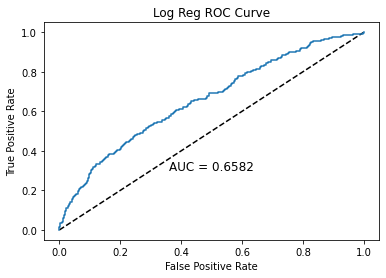

In [10]:
# plot ROC
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve")
plt.show();

In [11]:
param_grid = {
    'C': [0.01, 0.1, 'none'],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [1000, 1500, 2000]
}

grid_search = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Best Hyperparameters:  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score:  0.6667001110663829


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va

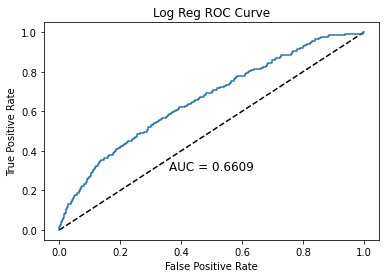

In [12]:
# re-plot w tuned parameters
log_tuned = LogisticRegression(C=0.1, max_iter=1000, penalty='l2', solver='lbfgs')
log_tuned.fit(X_train, y_train)

y_pred_tuned = log_tuned.predict(X_test)
y_pred_probs_tuned = log_tuned.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_tuned)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.text(0.5, 0.3, f'AUC = {roc_auc_score(y_test, y_pred_probs_tuned):.4f}', fontsize=12, ha='center')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve")
plt.show();

Slightly better! Hoorah!

In [13]:
# plain binary log metrics
accuracy = accuracy_score(y_test, y_pred_tuned)
precision = precision_score(y_test, y_pred_tuned, average='macro')
recall = recall_score(y_test, y_pred_tuned, average='macro')
f1 = f1_score(y_test, y_pred_tuned, average='macro')

print("Evaluation Scores:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Evaluation Scores:
Accuracy: 0.8207217694994179
Precision: 0.6970992622401073
Recall: 0.5107725439882698
F1-score: 0.47520549684217206


#### Oridinal Logistic Regression (cause what if I want to know how frequently I can expect my kitties to suckle?)

In [14]:
import statsmodels.api as sm

In [15]:
# re-working data so ws is in its original ordinal form 
df = cat_data.drop(columns=['Aggression_component', 'Shyness_component', 'Extraversion_component'])
encoded_df = encoded_df = pd.get_dummies(df, columns=['Breed_group'], prefix='B')

# assign X and y
X = encoded_df.drop(columns='Wool_sucking')
y = encoded_df['Wool_sucking']

# train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [19]:
# why do some logistic regression models need a constant added?
X_train = sm.add_constant(X_train)

ordinal_model = sm.MNLogit(y_train, X_train)
ordinal_results = ordinal_model.fit_regularized(method='l1', alpha=0.5)

print(ordinal_results.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0732922459978413
            Iterations: 855
            Function evaluations: 862
            Gradient evaluations: 855
                          MNLogit Regression Results                          
Dep. Variable:           Wool_sucking   No. Observations:                 4008
Model:                        MNLogit   Df Residuals:                     3825
Method:                           MLE   Df Model:                          176
Date:                Wed, 10 May 2023   Pseudo R-squ.:                 0.05426
Time:                        13:28:28   Log-Likelihood:                -4324.1
converged:                       True   LL-Null:                       -4572.2
Covariance Type:            nonrobust   LLR p-value:                 2.776e-32
     Wool_sucking=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

In [20]:
X_test = sm.add_constant(X_test)

# Make predictions on the testing set
y_pred = ordinal_results.predict(X_test)
y_pred = y_pred.idxmax(axis=1)  # Convert predicted probabilities to class labels

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.6833527357392316
Precision: 0.10657894736842105
Recall: 0.1255672546560397
F1-score: 0.10346996987540805


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I'm thinking we might not have enough data, especially for the classes I'm interested in (i.e., the suckers), for a well-performing ordinal classifier. Also this took like 5 minutes to run on my machine and I'm scare about how long a grid search could take. I don't see a way that I improve this significantly without gathering additional data...so I'm just going to rule this one out!

#### Random Forest:

In [24]:
from sklearn.ensemble import RandomForestClassifier

# multiclass run
X = encoded_df.drop(columns='Wool_sucking')
y = encoded_df['Wool_sucking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.6823734729493892
Precision: 0.23398383225969432
Recall: 0.14892303552329414
F1-score: 0.1299400670873308


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Woof, yeah even a tried and true ensemble poster boy can't multiclass with these few points :( 

In [27]:
# binary run
df = cat_data.drop(columns=['Aggression_component', 'Shyness_component', 'Extraversion_component'])
df['ws_binary'] = df['Wool_sucking'].replace({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1})
df.drop(columns='Wool_sucking', inplace=True)

encoded_df = pd.get_dummies(df, columns=['Breed_group'], prefix='B')

X = encoded_df.drop(columns='ws_binary')
y = encoded_df['ws_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8097731239092496
Precision: 0.5592294707576209
Recall: 0.5092065255976911
F1-score: 0.48122399142807304


For reference, the tuned log got:  
Evaluation Scores:  
Accuracy: 0.8207217694994179  
Precision: 0.6970992622401073  
Recall: 0.5107725439882698  
F1-score: 0.47520549684217206  

So I think good ol logistic regression (with tuned hyperparameters) is still winning. 